<a href="https://colab.research.google.com/github/rafelsiregar/imagemlp/blob/master/ML_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
!git clone https://github.com/rafelsiregar/imagemlp.git # Buat load dataset
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

fatal: destination path 'imagemlp' already exists and is not an empty directory.


In [73]:
def sigmoid(x):
  return 1/(1+exp(-x))

In [74]:
def resize(img, height, width):
  return cv2.resize(img,(height, width), interpolation = cv2.INTER_AREA)

def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [75]:
# Return 2 buah list isi dataset:
# list pertama adalah dataset (X) berupa ndarray
# list kedua adalah labelnya (y) berupa ndarray
# bisa langsung jadi parameter buat test_train_split()
def load_data():
  flowers = os.listdir('/content/imagemlp/flowers')
  print(flowers)

  label = dict(zip(flowers, [0, 1, 2]))

  X = []
  y = []

  for folder in flowers:
    images = os.listdir(os.path.join('/content/imagemlp/flowers', folder))
    X.extend([resize(
                grayscale(
                    cv2.imread(os.path.join('/content/imagemlp/flowers', folder, image))
                    ),
                    320,
                    240
                ) for image in images])
    y.extend([label[folder]] * len(images))
  
  return X, y

In [76]:
# fungsi main

def main():
  X, y = load_data()
  print("Gambar pertama dataset")
  cv2_imshow(X[0].reshape(240, 320))

['sunflower', 'dandelion', 'rose']
Gambar pertama dataset


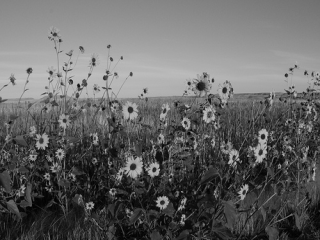

In [77]:
# run main

main()